In [1]:
import numpy as np
import pandas as pd
import cv2 , glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Conv2DTranspose , Conv2D , UpSampling2D,Input , MaxPool2D , Concatenate , BatchNormalization,Activation
from keras.models import Model 
from keras.callbacks import ReduceLROnPlateau , EarlyStopping
from keras.metrics import Recall , Precision
from keras.applications import MobileNetV2
from keras.utils import load_img,img_to_array

In [2]:
IMAGE_SIZE = 128

In [3]:
img_shape = (128,128,3)
mask_shape = (128,128,1)

In [4]:
def loadData():
    images = sorted(glob.glob('./DUTS-TR/DUTS-TR-Image/*.jpg'))
    mask = sorted(glob.glob('./DUTS-TR/DUTS-TR-Mask/*.png'))
    total_img = len(images)
    total_mask = len(mask)
    
    valid_size = int(total_img * .15)
    test_size = int(total_img * 0.05)
    
    X_train, X_test, y_train, y_test = train_test_split(images,mask,shuffle=True,random_state=42,test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,shuffle=True,random_state=42,test_size=valid_size) 
    
    return (X_train,y_train) , (X_val,y_val) , (X_test,y_test)

In [5]:
(train_x,train_y) , (val_x,val_y) , (test_x,test_y) = loadData()

In [6]:
len(train_x),len(train_y) , len(val_x),len(val_y), len(test_x),len(test_y) ,  

(8444, 8444, 1582, 1582, 527, 527)

In [7]:
def ImagePreprocess(url):
    img = load_img(url)
    img = img_to_array(img)
    img = cv2.resize(img,img_shape[:-1])
    img = img.astype('float32')
    img = img/255.0
    return img

def MaskPreprocess(url):
    img = cv2.imread(url,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,img_shape[:-1])
    img = img.astype('float32')
    img = img/255.0
    img = np.expand_dims(img,axis=-1)
    return img

In [8]:
train_img = np.zeros(((len(train_x),)+img_shape),dtype='float32')
train_mask = np.zeros(((len(train_y),)+mask_shape),dtype='float32')
test_img = np.zeros(((len(test_x),)+img_shape),dtype='float32')
test_mask = np.zeros(((len(test_y),)+mask_shape),dtype='float32')
val_img = np.zeros(((len(val_x),)+img_shape),dtype='float32')
val_mask = np.zeros(((len(val_y),)+mask_shape),dtype='float32')

In [9]:
train_img.shape , train_mask.shape , val_img.shape , val_mask.shape , test_img.shape,test_mask.shape

((8444, 128, 128, 3),
 (8444, 128, 128, 1),
 (1582, 128, 128, 3),
 (1582, 128, 128, 1),
 (527, 128, 128, 3),
 (527, 128, 128, 1))

In [10]:
def getArray(names,df):
    for i in range(names.shape[0]):
        df[i] = ImagePreprocess(names[i])
    return df

In [11]:
for i in range(train_img.shape[0]):
    train_img[i] = ImagePreprocess(train_x[i])

In [12]:
for i in range(train_mask.shape[0]):
    train_mask[i] = MaskPreprocess(train_y[i])

In [13]:
for i in range(test_img.shape[0]):
    test_img[i] = ImagePreprocess(test_x[i])
    
for i in range(test_mask.shape[0]):
    test_mask[i] = MaskPreprocess(test_y[i])

In [14]:
for i in range(val_img.shape[0]):
    val_img[i] = ImagePreprocess(val_x[i])
    
for i in range(val_mask.shape[0]):
    val_mask[i] = MaskPreprocess(val_y[i])

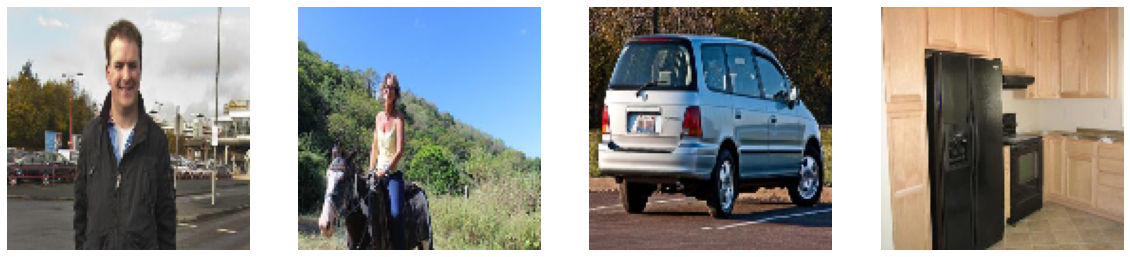

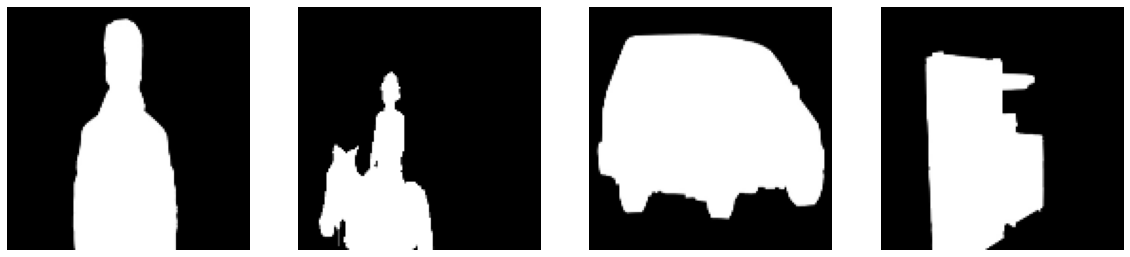

In [15]:
fig , ax = plt.subplots(1,4,figsize=(20,10))

for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(train_img[i])
    
fig , ax = plt.subplots(1,4,figsize=(20,10))

for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(cv2.cvtColor(train_mask[i],cv2.COLOR_BGR2RGB))

In [16]:
def model():
    """Setting the input shape"""
    inputs = Input(shape=(128, 128, 3), name="input_image") 
    
    """Encoder based of pretrained Model of Mobilenetv2"""
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    
    """We select the final ReLU activation layer for each feature map size 
    required for skip-connections."""
    
    skip_connection_names = ["input_image", 
                             "block_1_expand_relu", 
                             "block_3_expand_relu", 
                             "block_6_expand_relu"]
    
    """block_13_expand_relu layer will be used as bridge connection for upsampling"""
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    """upstack  upsampling sizes """
    f = [16, 32, 48, 64]
    x = encoder_output
    """traverse skip_connections_name in reverse dir , apply upsampling + skip connection , store in x , use this x 
    again for further upsampling till the segmented image reshaped to original"""
    
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    """Used Sigmoid activatation as our problem in hand is a binary classfication problem . Model have to locate the 
    object in the image . if pixel belongs to the object then color it to white else black"""
    
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [17]:
segmentModel = model()

Metal device set to: Apple M1


2022-08-14 14:26:45.862162: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-14 14:26:45.862254: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
segmentModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']           

In [19]:
smooth = 1e-15
"""The Dice coefficient is widely used metric in computer vision community to calculate the similarity between 
two images.
The image generated will be compared by ground image and diff in similarity score will be used backpropogate
"""
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [20]:
"""Nadam is an optimiser technique that incorporates Nesterov momentum and can result in better performance 
of the optimization algorithm.
"""
opt = tf.keras.optimizers.Nadam(1e-4)
metrics = [dice_coef, Recall(), Precision()]
segmentModel.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [21]:
"""TO customize the behavior of the model during training, evaluation, or inference.Callback from tensorflow is
used"""
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [22]:
BATCH = 128

In [23]:
train_steps = len(train_img)//BATCH
valid_steps = len(val_img)//BATCH

In [24]:
history = segmentModel.fit(
    train_img,
    train_mask,
    validation_data=(val_img,val_mask),
    epochs=50,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/50


2022-08-14 14:26:50.381560: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-14 14:26:55.741562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - ETA: 0s - loss: 0.4308 - dice_coef: 0.5693 - recall: 0.8299 - precision: 0.6172

2022-08-14 14:29:10.086184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 146s 2s/step - loss: 0.4308 - dice_coef: 0.5693 - recall: 0.8299 - precision: 0.6172 - val_loss: 0.4398 - val_dice_coef: 0.5602 - val_recall: 0.9914 - val_precision: 0.4717 - lr: 1.0000e-04
Epoch 2/50
65/65 [==============================] - 127s 2s/step - loss: 0.2879 - dice_coef: 0.7121 - recall: 0.9263 - precision: 0.7987 - val_loss: 0.3482 - val_dice_coef: 0.6518 - val_recall: 0.9057 - val_precision: 0.7767 - lr: 1.0000e-04
Epoch 3/50
65/65 [==============================] - 126s 2s/step - loss: 0.2629 - dice_coef: 0.7371 - recall: 0.9283 - precision: 0.8252 - val_loss: 0.3358 - val_dice_coef: 0.6642 - val_recall: 0.8064 - val_precision: 0.8883 - lr: 1.0000e-04
Epoch 4/50
65/65 [==============================] - 122s 2s/step - loss: 0.2466 - dice_coef: 0.7534 - recall: 0.9290 - precision: 0.8424 - val_loss: 0.3308 - val_dice_coef: 0.6692 - val_recall: 0.7309 - val_precision: 0.9295 - lr: 1.0000e-04
Epoch 5/50
65/65 [=========================

In [35]:
segmentModel.save('./SegmentMobilenetV2.h5')

In [25]:
segmentModel.evaluate(test_img,test_mask)

17/17 [==============================] - 3s 109ms/step - loss: 0.1572 - dice_coef: 0.8414 - recall: 0.8857 - precision: 0.9080


[0.1572217047214508,
 0.8414022922515869,
 0.8856503963470459,
 0.9080396890640259]

In [31]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (128, 128))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [32]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 22ms/step


/var/folders/h7/tc39r5gj0_q6xm_2khch31900000gn/T/ipykernel_62132/835385703.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


1/1 [==============================] - 0s 22ms/step


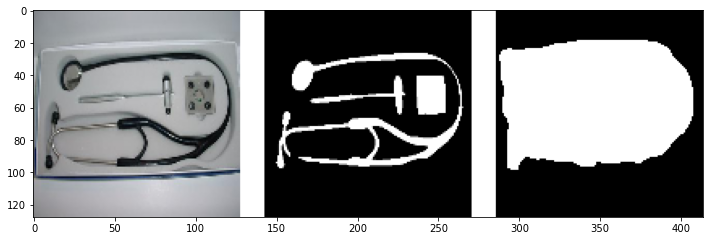

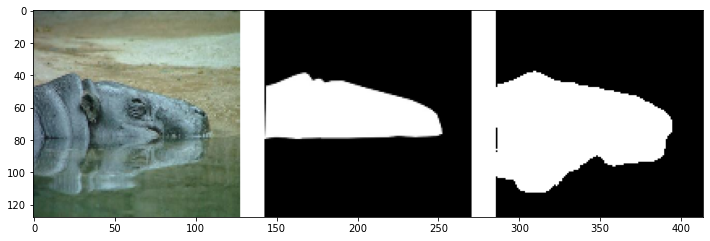

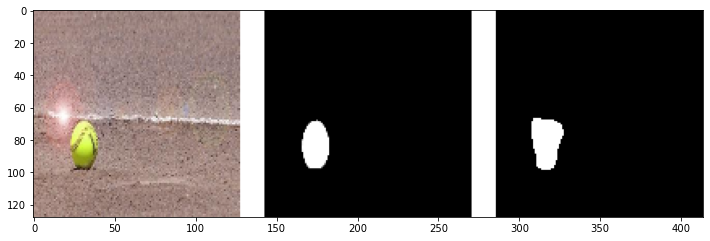

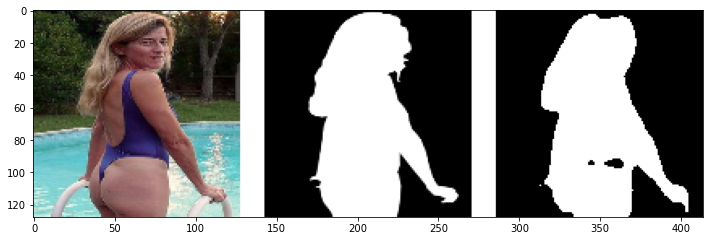

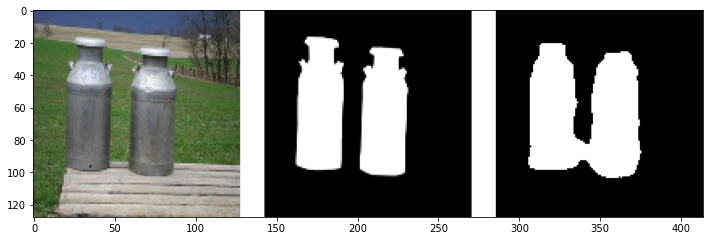

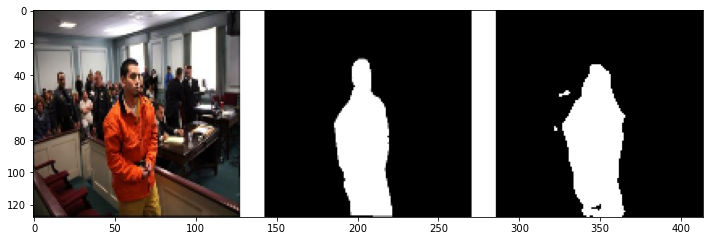

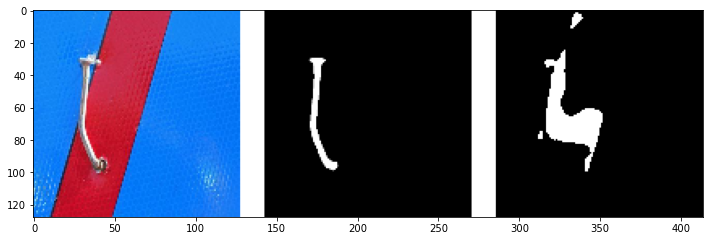

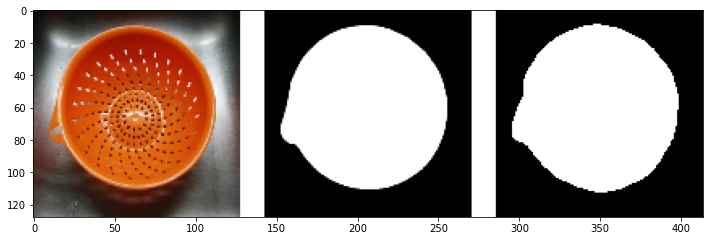

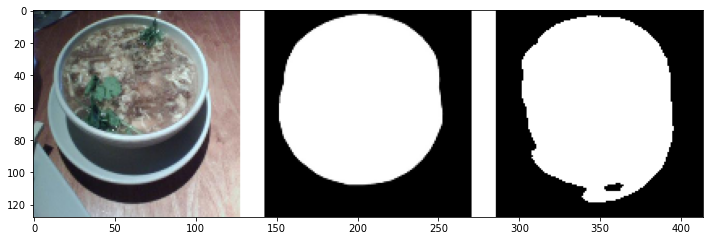

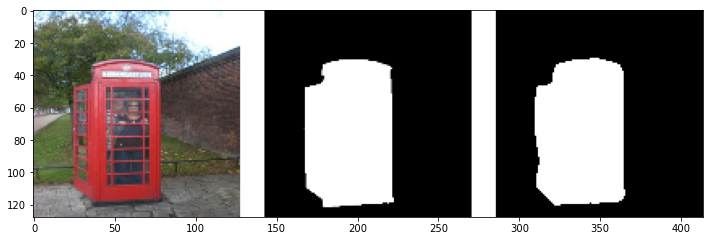

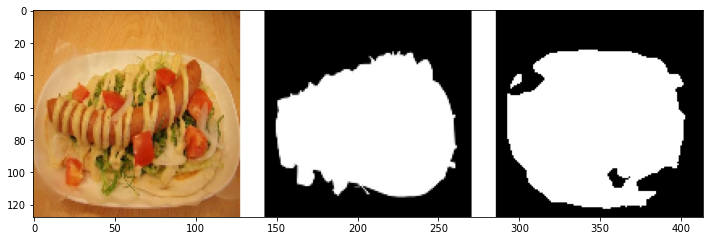

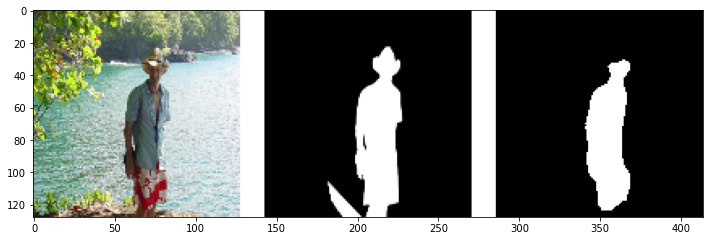

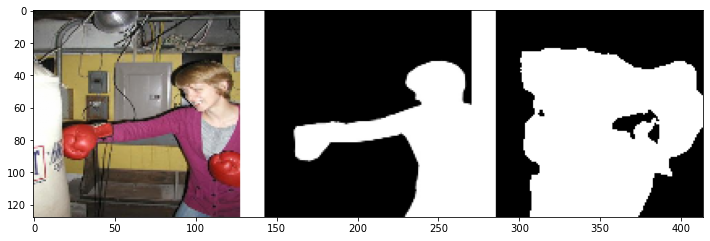

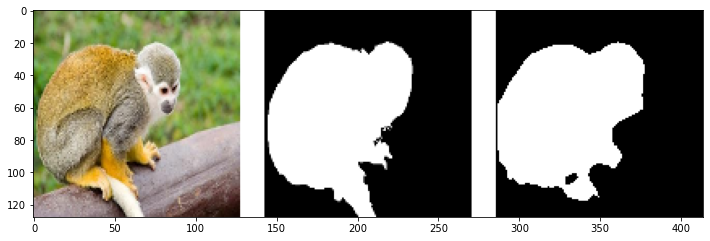

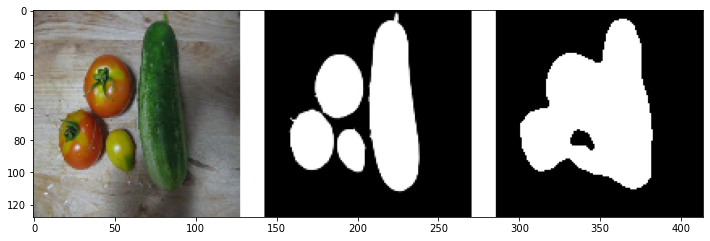

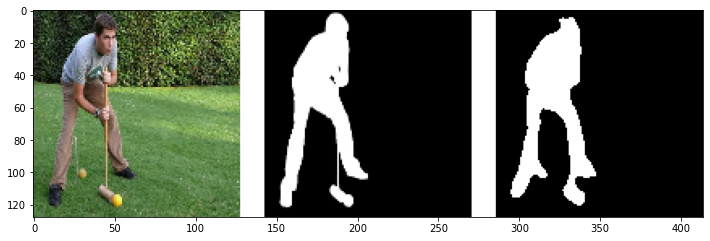

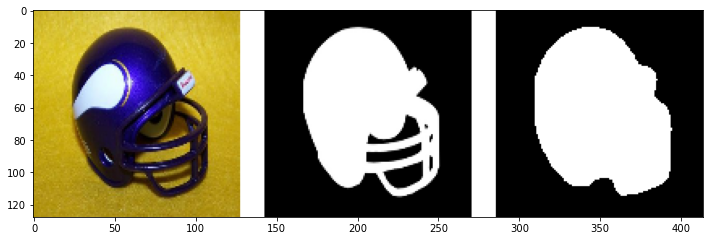

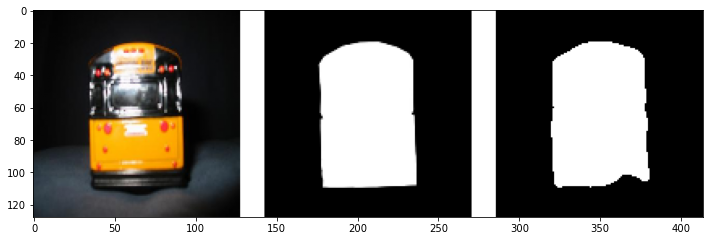

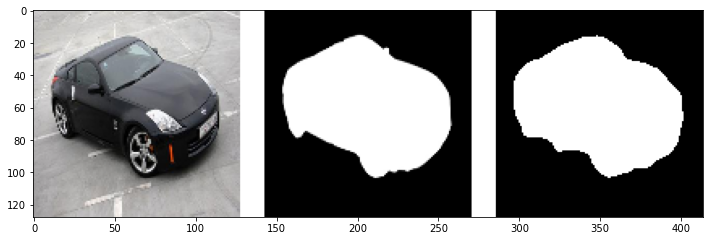

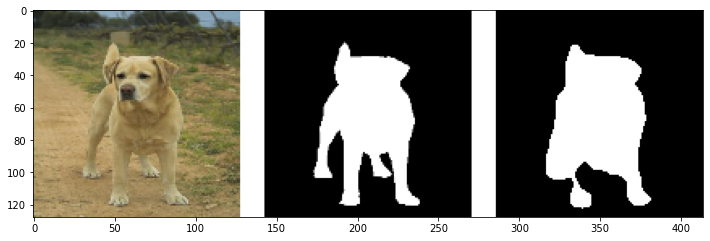

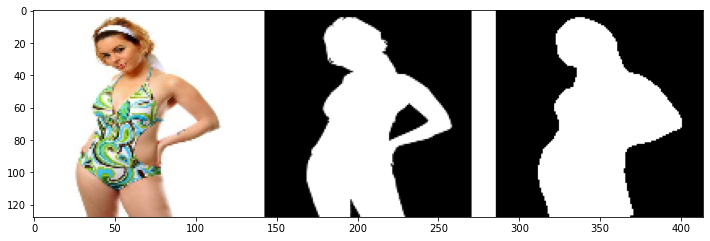

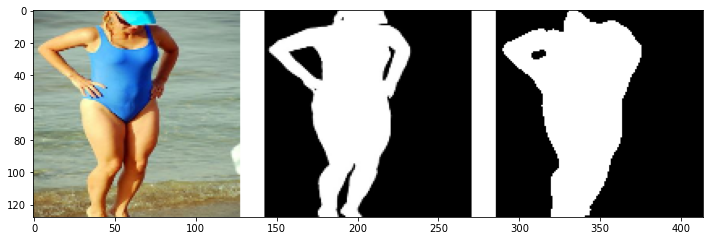

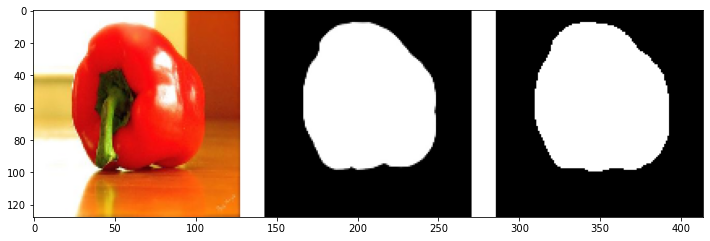

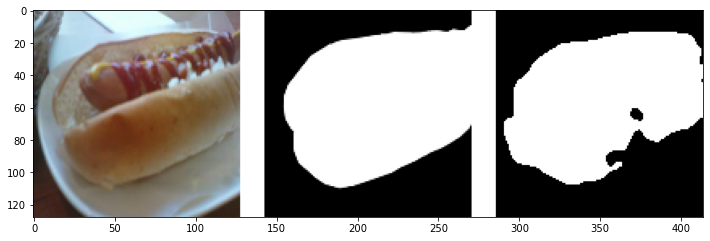

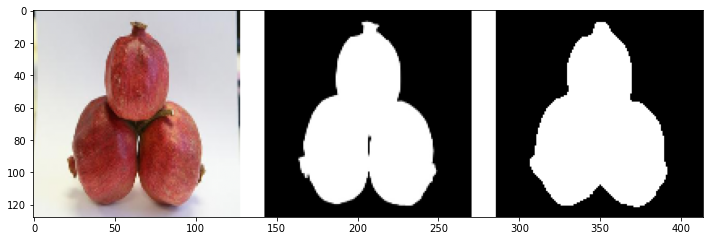

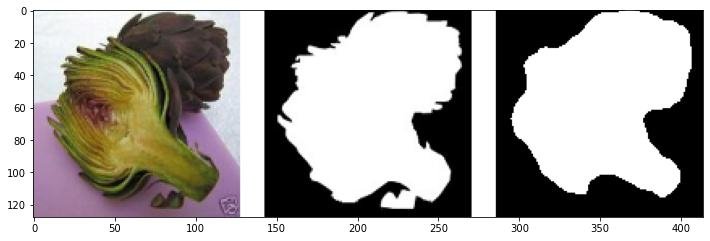

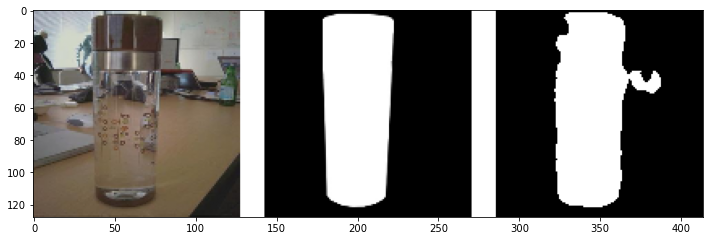

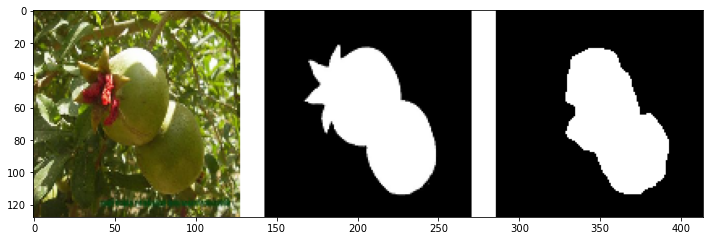

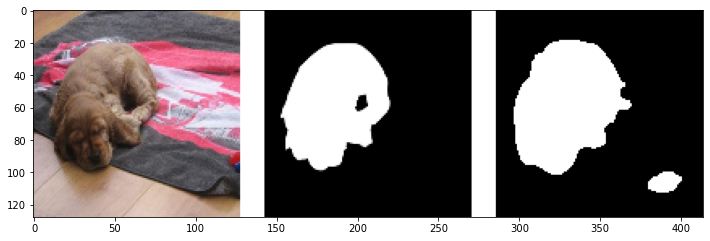

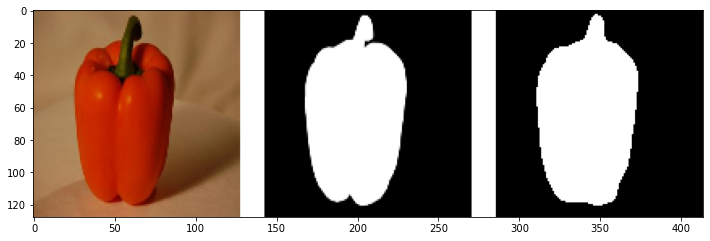

In [36]:
for i, (x, y) in enumerate(zip(test_x[30:60], test_y[30:60])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = segmentModel.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 15, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)